# Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import rawpy
import cv2

root = "exercise_2_data/"

def build_channel_masks(array, green_first = True, one_value = False):
    Y_channel_mask = np.zeros_like(array)
    C1_channel_mask = np.zeros_like(array)
    C2_channel_mask = np.zeros_like(array)
    
    if not one_value:
        if green_first:
            Y_channel_mask[::2, 0::2] = array[::2, 0::2]
            Y_channel_mask[1::2, 1::2] = array[1::2, 1::2]
            C1_channel_mask[::2, 1::2] = array[::2, 1::2]
            C2_channel_mask[1::2, 0::2] = array[1::2, 0::2]
        else:
            Y_channel_mask[0::2, 1::2] = array[0::2, 1::2]
            Y_channel_mask[1::2, 0::2] = array[1::2, 0::2]
            C1_channel_mask[1::2, 1::2] = array[1::2, 1::2]
            C2_channel_mask[0::2, 0::2] = array[0::2, 0::2]
    else:
        Y_channel_mask[0::2, 1::2] = 1
        Y_channel_mask[1::2, 0::2] = 1
        C1_channel_mask[1::2, 1::2] = 1
        C2_channel_mask[0::2, 0::2] = 1
    return Y_channel_mask, C1_channel_mask, C2_channel_mask

def show_image(image, title, hide_axis = False, hide_colorbar = False):
    plt.imshow(image)
    plt.title(title)
    if hide_axis:
        plt.axis('off')
    if not hide_colorbar:
        plt.colorbar()
    plt.show()

# Part 1

Loaded array of size (4014, 6020)
The pens, from top to bottom, are red, green and blue


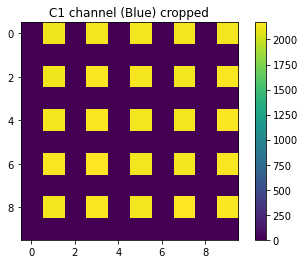

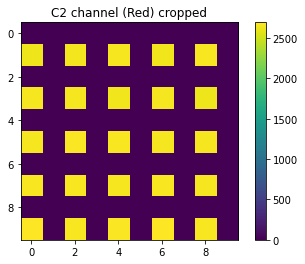

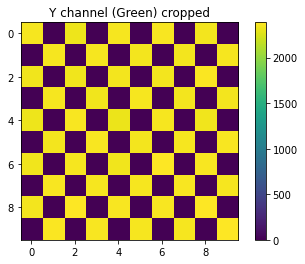

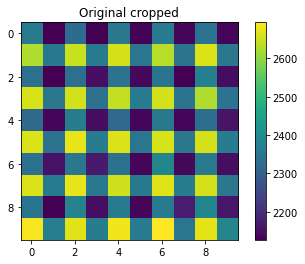

In [2]:
array_1 = np.load(f'{root}01/IMG_9939.npy')
print('Loaded array of size', array_1.shape)
print('The pens, from top to bottom, are red, green and blue')

y_1, c1_1, c2_1 = build_channel_masks(array_1, green_first = True)
cropped_red_C1 = c1_1[1440:1450, 2100:2110]
cropped_red_C2 = c2_1[1440:1450, 2100:2110]
cropped_red_Y = y_1[1440:1450, 2100:2110]

cropped_red = array_1[1440:1450, 2100:2110]

show_image(cropped_red_C1, 'C1 channel (Blue) cropped')
show_image(cropped_red_C2, 'C2 channel (Red) cropped')
show_image(cropped_red_Y, 'Y channel (Green) cropped')
show_image(cropped_red, 'Original cropped')

# Part 2

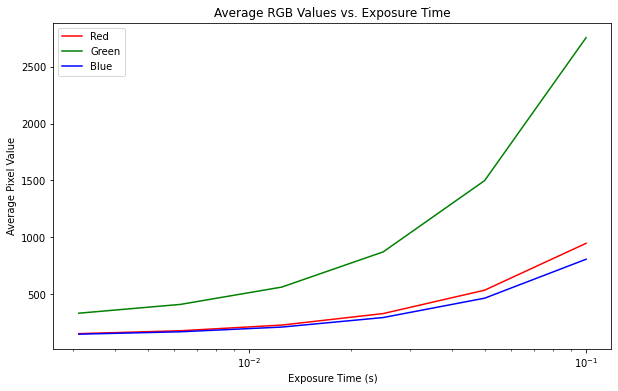

In [3]:
dataset_2 = ["02/IMG_3044.CR3", "02/IMG_3045.CR3", "02/IMG_3046.CR3", "02/IMG_3047.CR3", "02/IMG_3048.CR3", "02/IMG_3049.CR3"]
exposure_times = np.array([1/10, 1/20, 1/40, 1/80, 1/160, 1/320])

avg_red = []
avg_green = []
avg_blue = []

for i in range(len(dataset_2)):
    raw = rawpy.imread(root + dataset_2[i])
    array_2 = np.array(raw.raw_image_visible)
    y_2, c1_2, c2_2 = build_channel_masks(array_2, green_first = False)
    avg_red.append(np.mean(c2_2))
    avg_green.append(np.mean(y_2))
    avg_blue.append(np.mean(c1_2))

plt.figure(figsize=(10, 6))
plt.plot(exposure_times, avg_red, 'r-', label='Red')
plt.plot(exposure_times, avg_green, 'g-', label='Green')
plt.plot(exposure_times, avg_blue, 'b-', label='Blue')
plt.xlabel('Exposure Time (s)')
plt.ylabel('Average Pixel Value')
plt.title('Average RGB Values vs. Exposure Time')
plt.legend()
plt.xscale('log')
plt.show()

# Part 3

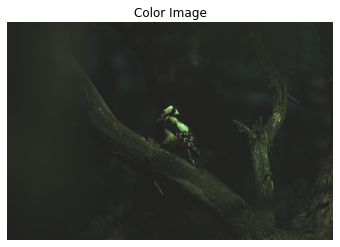

True

In [4]:
def demosaic_channel(X, M):
    K = np.ones((3, 3))
    MX = M * X
    numerator = convolve2d(MX, K, mode='same', boundary='symm')
    denominator = convolve2d(M, K, mode='same', boundary='symm')
    with np.errstate(divide='ignore', invalid='ignore'):
        C = numerator / denominator
        C[denominator == 0] = 0  # Safeguard for division by zero
    return C

def convert_to_8bit(image, bit_depth=14):
    return (image / (2**bit_depth - 1)) * 255

def demosaicing(image, y, c1, c2):
    r_channel = demosaic_channel(image, c2)
    g_channel = demosaic_channel(image, y)
    b_channel = demosaic_channel(image, c1)
    return r_channel, g_channel, b_channel

def demosaicing_rgb(image, y, c1, c2, with_8bit_conversion=True):
    r_channel, g_channel, b_channel = demosaicing(image, y, c1, c2)

    if with_8bit_conversion:
        r_channel = convert_to_8bit(r_channel)
        g_channel = convert_to_8bit(g_channel)
        b_channel = convert_to_8bit(b_channel)

    return np.dstack((r_channel, g_channel, b_channel)).astype(np.uint8)


raw = rawpy.imread(f"{root}03/IMG_4782.CR3")
array_3 = np.array(raw.raw_image_visible)

y_3, c1_3, c2_3 = build_channel_masks(array_3, green_first = False, one_value=True)

color_image = demosaicing_rgb(array_3, y_3, c1_3, c2_3, with_8bit_conversion=True)

show_image(color_image, 'Color Image', hide_axis=True, hide_colorbar=True)
# Save demosaiced image
cv2.imwrite("demosaiced_image.png", cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR))

# Part 4
Luminosity

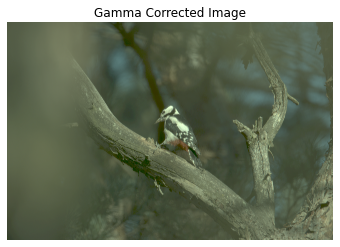

True

In [5]:
def apply_gamma_correction(image, gamma):
    a = np.percentile(image, 0.01)
    b = np.percentile(image, 99.99)
    normalized_image = (image - a) / (b - a)
    normalized_image[normalized_image < 0] = 0
    normalized_image[normalized_image > 1] = 1
    gamma_corrected_image = normalized_image ** gamma
    # Convert to 8-bit type for display, scale up to the 8-bit range
    gamma_corrected_image = 255 * gamma_corrected_image
    gamma_corrected_image[gamma_corrected_image < 0] = 0
    gamma_corrected_image[gamma_corrected_image > 255] = 255
    gamma_corrected_image = gamma_corrected_image.astype(np.uint8)
    return gamma_corrected_image

gamma = 0.3
gamma_corrected_image = apply_gamma_correction(color_image, gamma)

show_image(gamma_corrected_image, 'Gamma Corrected Image', hide_colorbar=True, hide_axis=True)
# Save the gamma corrected image
cv2.imwrite('gamma_corrected_image.png', cv2.cvtColor(gamma_corrected_image, cv2.COLOR_RGB2BGR))

# Part 5
White balance

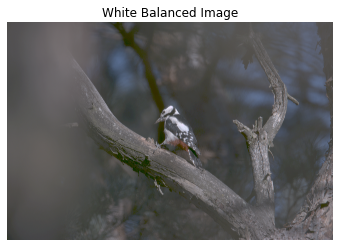

True

In [6]:
def white_balance(gamma_corrected_image):

  mi = np.mean(gamma_corrected_image)

  # Apply white balance to each channel
  white_balanced_image = np.zeros_like(gamma_corrected_image, dtype=np.float64)
  for channel in range(3):  # Iterate over RGB channels
      mc = np.mean(gamma_corrected_image[:, :, channel])
      white_balanced_image[:, :, channel] = gamma_corrected_image[:, :, channel] * (mi / mc)

  # Clip values to a maximum of 255
  white_balanced_image[white_balanced_image > 255] = 255

  # Convert to uint8 type for display
  white_balanced_image = white_balanced_image.astype(np.uint8)

  return white_balanced_image

white_balanced_image = white_balance(gamma_corrected_image)
show_image(white_balanced_image, 'White Balanced Image', hide_colorbar=True, hide_axis=True)
# Save the white balanced image
cv2.imwrite('white_balanced_image.png', cv2.cvtColor(white_balanced_image, cv2.COLOR_RGB2BGR))

# Part 6

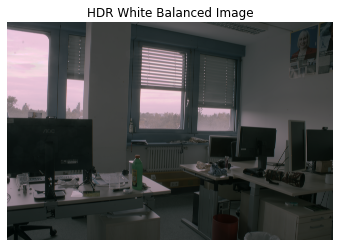

True

In [7]:
def hdr_combination(images, exposure_times):
    h = images[0] / exposure_times[0]  # base image normalized by its exposure time
    for i, img in enumerate(images[1:], start=1):
        # Scaling factor based on exposure times
        scale_factor = exposure_times[0] / exposure_times[i]
        img_scaled = img * scale_factor

        # Apply threshold to integrate images into HDR composite
        threshold = 0.8 * h.max()
        h = np.where(img_scaled > threshold, img_scaled, h)

    # Apply logarithmic scaling to compress the dynamic range
    hdr_image_log = np.log1p(h)
    # Normalize to the range [0, 255]
    hdr_image_norm = 255 * (hdr_image_log - hdr_image_log.min()) / (hdr_image_log.max() - hdr_image_log.min())
    return hdr_image_norm.astype(np.uint8)

def read_raw_image(file_path):
    with rawpy.imread(root+file_path) as raw:
        # Extract the raw data
        raw_data = raw.raw_image_visible.copy()
    return raw_data

exposure_times_hdr = [1, 1/2, 1/4, 1/8, 1/16, 1/32, 1/64, 1/128, 1/256, 1/512, 1/1024]
dataset_6 = ["06/00.CR3", "06/01.CR3", "06/02.CR3", "06/03.CR3", "06/04.CR3", "06/05.CR3", "06/06.CR3", "06/07.CR3", "06/08.CR3", "06/09.CR3", "06/10.CR3"]
images = [read_raw_image(file_path) for file_path in dataset_6]

hdr_image = hdr_combination(images, exposure_times_hdr)

y_4, c1_4, c2_4 = build_channel_masks(hdr_image, green_first = False, one_value=True)
hdr_demosaiced = demosaicing_rgb(hdr_image, y_4, c1_4, c2_4, with_8bit_conversion=False)

hdr_white_balanced_image = white_balance(hdr_demosaiced)
show_image(hdr_white_balanced_image, 'HDR White Balanced Image', hide_colorbar=True, hide_axis=True)
# Save the HDR image
cv2.imwrite('hdr_image.png', cv2.cvtColor(hdr_white_balanced_image, cv2.COLOR_RGB2BGR))

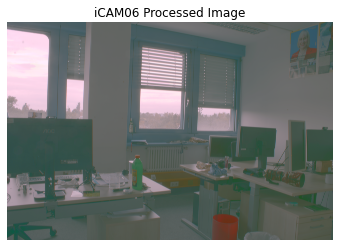

True

In [8]:
import cv2 

def iCAM06(rgb_image, output_range=4):
    # Calculate intensity
    intensity = (20 * rgb_image[..., 0] + 40 * rgb_image[..., 1] + rgb_image[..., 2]) / 61

    # Normalize RGB based on intensity
    r, g, b = rgb_image[..., 0] / intensity, rgb_image[..., 1] / intensity, rgb_image[..., 2] / intensity

    # Bilateral filter on log intensity
    log_intensity = np.log(intensity + 1)  # Avoid log(0)
    log_base = cv2.bilateralFilter(log_intensity.astype(np.float32), d=5, sigmaColor=75, sigmaSpace=75)
    log_detail = log_intensity - log_base

    # Compression
    compression = np.log(output_range) / (log_base.max() - log_base.min())
    log_offset = -log_base.max() * compression
    output_intensity = np.exp(log_base * compression + log_offset + log_detail)

    # Reconstruct the final image
    final_r = r * output_intensity
    final_g = g * output_intensity
    final_b = b * output_intensity
    final_image = np.stack((final_r, final_g, final_b), axis=-1)

    # Clip and convert to 8-bit
    final_image = np.clip(final_image * 255, 0, 255).astype(np.uint8)
    return final_image

# Apply iCAM06 to an example RGB image

normalized_hdr = hdr_white_balanced_image / 255
output_image = iCAM06(normalized_hdr)
show_image(output_image, 'iCAM06 Processed Image', hide_colorbar=True, hide_axis=True)
# Save the iCAM06 processed image
cv2.imwrite('icam06_image.png', cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR))


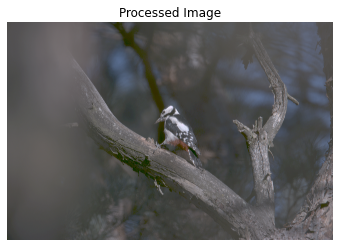

True

In [9]:
def process_raw(raw_file):
    raw = rawpy.imread(raw_file)
    array = np.array(raw.raw_image_visible)

    y, c1, c2 = build_channel_masks(array, green_first = False, one_value=True)

    color_image = demosaicing_rgb(array, y, c1, c2, with_8bit_conversion=True)

    gamma = 0.3
    gamma_corrected_image = apply_gamma_correction(color_image, gamma)

    white_balanced_image = white_balance(gamma_corrected_image)

    return white_balanced_image

processed_raw = process_raw(f"{root}03/IMG_4782.CR3")
show_image(processed_raw, 'Processed Image', hide_colorbar=True, hide_axis=True)
# Save the processed image
cv2.imwrite('processed_image.jpg', cv2.cvtColor(processed_raw, cv2.COLOR_RGB2BGR))